## import packages

In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext
import tqdm

## Set random seed for reproducibility

In [3]:
seed = 1234

np.random.seed(seed) # Seed NumPy’s RNG
torch.manual_seed(seed) # Seed PyTorch’s CPU RNG
torch.cuda.manual_seed(seed) # Seed PyTorch’s GPU RNG
torch.backends.cudnn.deterministic = True # Ensure cuDNN uses deterministic algorithms

## Load the IMDB dataset, retrieving both the training and test splits

In [ ]:
# train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

In [4]:
from datasets import load_from_disk

train_data = load_from_disk("imdb_train")
test_data  = load_from_disk("imdb_test")

print(train_data)      
print(train_data[0])  

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered 

## Initialize the basic English tokenizer from torchtext

In [5]:
tokenizer = get_tokenizer("basic_english")

## Define a function to tokenize a single dataset example:
 - Apply the tokenizer to the "text" field
 - Truncate the token list to `max_length`
 - Return a dict containing the tokens and their count

In [6]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

## Apply the tokenizer to each example in the training split and test split, passing in both the tokenizer instance and the truncation length

In [7]:
# Define the maximum number of tokens per example
max_length = 256

train_data = train_data.map(
    tokenize_example,
    fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

test_data = test_data.map(
    tokenize_example,
    fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

## Split the preprocessed training data into new train and validation sets

In [8]:
# Fraction of examples to reserve for validation
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

## iterate over train_data["tokens"], apply the frequency filter, prepend the special tokens, and assign each token a unique integer index.

In [9]:
min_freq = 5 # only keep tokens that appear at least 5 times.
special_tokens = ["<unk>", "<pad>"] # <unk> for out‑of‑vocabulary tokens, <pad> for sequence padding.

vocab = build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [10]:
unk_index = vocab["<unk>"] # Retrieves the integer ID reserved for the “unknown” token, used to represent any out‑of‑vocabulary word.

pad_index = vocab["<pad>"] # Retrieves the integer ID reserved for the padding token, used to pad shorter sequences to a fixed length.

In [11]:
vocab.set_default_index(unk_index) # configures the vocabulary to return `unk_index` for any token not found, mapping all out‑of‑vocabulary words to `<unk>`.

## Defines a function that converts token lists into numeric ID sequences.

In [12]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"]) # Maps each token in `example["tokens"]` to its corresponding integer index from the vocabulary.
    return {"ids": ids} # Returns a dictionary containing the list of token IDs under the `"ids"` key.

## Apply numericalization to the training, validation and test set
  runs the `numericalize_example` function on each example, converting its token list into a sequence of integer IDs using the vocabulary.



In [13]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   6%|▌         | 1163/18750 [00:00<00:07, 2266.57 examples/s]

Map: 100%|██████████| 25000/25000 [00:06<00:00, 3603.61 examples/s]


## Configure PyTorch output format:
  use `with_format(type="torch", columns=[...])` so that accessing examples yields PyTorch tensors.

  * `ids`: token ID sequences
  * `label`: ground‑truth sentiment label
  * `length`: original token count

In [14]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [15]:
# train_data.reset_format()
train_data[0] 

{'label': tensor(1),
 'length': tensor(135),
 'ids': tensor([  180,     4,    14,    10,   191,   841,    34,     7,     2,   121,
            98,   816,    50,     8,  1516,     2,   380,     7,     2,   184,
             3,     8,   805,    14,    18,    10,     8,   805,  2246,   429,
             3,    12,   347,    15,     2,   388,  1025,     9,    16,    76,
             5,    64,     7, 11198,     3,     2,  9212,    17,   761,     4,
          7812,  5460,   198,    37,     4,     6,  3653,  3683,    17,   226,
             5, 11893,     3,    53,     7,    15,  3310,   354,     5,   689,
             4,     0,  5471,     3,  2706,  3826,     9,    16,   246,    13,
            14,    18,  1111,    33,    17,   126,   188,     8,    35,   597,
           181,    19,     5,    34,  3942,  1381,    13,     2,  5370,     3,
            32,  4228,    10,    41,  2825,     8,    37,     3,     2,  4411,
          1141,   213,  2655,     6, 16946,  3729,   590,  4845,     8,  2416,


## return a function that prepares a batch for the DataLoader.
* **Extract `ids`**: gathers each example’s token ID tensor, then pads them to the same length using `pad_index`.
* **Extract `length`**: collects the original (pre‑padding) sequence lengths and stacks them into a tensor.
* **Extract `label`**: collects the sentiment labels and stacks them into a tensor.
* **Return batch**: a dict with keys

  * `ids`: padded token ID tensor of shape `(batch_size, max_seq_len)`
  * `length`: tensor of original sequence lengths `(batch_size,)`
  * `label`: tensor of labels `(batch_size,)`


In [16]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

## define a helper function that returns a PyTorch DataLoader configured for the tokenized dataset.

In [17]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index) # builds a collation function that pads variable‑length sequences using `pad_index`, and stacks lengths and labels.
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

## define batch_size and DataLoader for the training set, validation set and the test set.


In [18]:
batch_size = 256

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## Build a LSTM model here, called LSTM, that takes in as its input a sequence of token IDs and outputs logits.
## In this model, we use nn.Embedding to convert the token IDs into embedding vectors.

In [19]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int = 1,
        bidirectional: bool = False,
        dropout: float = 0.2,
        pad_index: int = None,
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)
        # LSTM layer with optional bidirectionality
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0),
        )
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        # Fully connected layer mapping LSTM outputs to logits
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor = None) -> torch.Tensor:
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)

        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
            )
            _, (hidden, _) = self.lstm(packed)
        else:
            _, (hidden, _) = self.lstm(embedded)

        # hidden: (num_layers * num_directions, batch, hidden_dim)
        if self.bidirectional:
            # last layer’s forward and backward states
            forward_h = hidden[-2]   # (batch, hidden_dim)
            backward_h = hidden[-1]  # (batch, hidden_dim)
            out = torch.cat((forward_h, backward_h), dim=1)  # (batch, hidden_dim*2)
        else:
            out = hidden[-1]  # (batch, hidden_dim)

        out = self.dropout(out)
        logits = self.fc(out)  # (batch, output_dim)
        return logits


## Model instantiation with parameters:
* **`vocab_size = len(vocab)`**
  Number of unique tokens in your vocabulary, used to size the embedding matrix.

* **`embedding_dim = 300`**
  Dimensionality of each token’s embedding vector.

* **`hidden_dim = 300`**
  Size of the LSTM’s hidden state per direction.

* **`output_dim = len(train_data.unique("label"))`**
  Number of target classes (e.g., 2 for binary sentiment).

* **`n_layers = 2`**
  Number of stacked LSTM layers.

* **`bidirectional = True`**
  Enables a two‑directional LSTM (forward & backward).

* **`dropout_rate = 0.5`**
  Dropout probability between LSTM layers and before the final layer.


  Creates an LSTM classifier with embeddings, a 2‑layer bidirectional LSTM (hidden size 300), 50% dropout, and a final linear layer mapping to our output classes.


In [20]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

## print the total count of trainable parameters.

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 10,101,302 trainable parameters


## Ensure every Linear and LSTM layer in `model` uses our custom initialization before training.

* **`initialize_weights(m)`**

  * For **`nn.Linear`** layers:

    * **`m.weight`** initialized with Xavier normal (good for layers with symmetric activations).
    * **`m.bias`** set to zeros.
  * For **`nn.LSTM`** layers:

    * All **bias** parameters zeroed.
    * All **weight** parameters initialized orthogonally (helps preserve gradients over long sequences).





In [22]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [23]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(21635, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=600, out_features=2, bias=True)
)

## load the pre‑trained GloVe embeddings into a Vectors object, providing access to

  * `vectors.stoi`: a mapping from token to its row index in the embedding matrix
  * `vectors.vectors`: a `(num_tokens, 300)` tensor of embedding weights


In [27]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [22:07, 1.64MB/s]                                
100%|█████████▉| 2196016/2196017 [03:02<00:00, 12029.14it/s]


In [ ]:
# from torchtext.vocab import GloVe

# vectors = GloVe(
#     name="840B",
#     dim=300,
#     cache=".vector_cache"    
# )

In [25]:
vectors.vectors.size()

torch.Size([2196017, 300])

## looks up the GloVe vector for each token in our vocabulary, producing a `(vocab_size, embedding_dim)` tensor where row i corresponds to the embedding of token i.


In [26]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

## Assign pretrained embeddings

In [27]:
model.embedding.weight.data = pretrained_embedding

## Set learning rate, adam optimizer, ce loss and gpu as device.

In [28]:
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

In [29]:
criterion = nn.CrossEntropyLoss()

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [49]:
model = model.to(device)
criterion = criterion.to(device)

## define training and evaluating process.

In [33]:
import torch
import numpy as np
import tqdm

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    torch.set_grad_enabled(True)        # ensure tracking is on
    # turn on anomaly detection for backward()
    torch.autograd.set_detect_anomaly(True)

    epoch_losses = []
    epoch_accs   = []

    for batch in tqdm.tqdm(dataloader, desc="training..."):
        # move inputs to device
        ids    = batch["ids"].to(device)
        lengths= batch["length"].to(device)
        labels = batch["label"].to(device)

        # forward + loss
        predictions = model(ids, lengths)
        loss        = criterion(predictions, labels)
        acc         = get_accuracy(predictions, labels)

        # backward + step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record metrics
        epoch_losses.append(loss.item())
        epoch_accs.append(acc.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)


In [35]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [36]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

## train the model

In [37]:
torch.autograd.set_detect_anomaly(True)

n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 25/25 [00:00<00:00, 43.22it/s]


epoch: 0
train_loss: 0.562, train_acc: 0.689
valid_loss: 0.478, valid_acc: 0.787


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 41.24it/s]


epoch: 1
train_loss: 0.459, train_acc: 0.791
valid_loss: 0.401, valid_acc: 0.824


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 40.59it/s]


epoch: 2
train_loss: 0.390, train_acc: 0.825
valid_loss: 0.800, valid_acc: 0.530


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 40.07it/s]


epoch: 3
train_loss: 0.477, train_acc: 0.779
valid_loss: 0.433, valid_acc: 0.797


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 42.23it/s]


epoch: 4
train_loss: 0.438, train_acc: 0.804
valid_loss: 0.509, valid_acc: 0.734


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 42.20it/s]


epoch: 5
train_loss: 0.440, train_acc: 0.795
valid_loss: 0.414, valid_acc: 0.812


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 40.43it/s]


epoch: 6
train_loss: 0.348, train_acc: 0.848
valid_loss: 0.345, valid_acc: 0.851


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 40.46it/s]


epoch: 7
train_loss: 0.282, train_acc: 0.882
valid_loss: 0.329, valid_acc: 0.859


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 39.78it/s]


epoch: 8
train_loss: 0.235, train_acc: 0.907
valid_loss: 0.325, valid_acc: 0.860


evaluating...: 100%|██████████| 25/25 [00:00<00:00, 39.84it/s]

epoch: 9
train_loss: 0.203, train_acc: 0.924
valid_loss: 0.336, valid_acc: 0.882


## visualize training and validation losses and accuracies

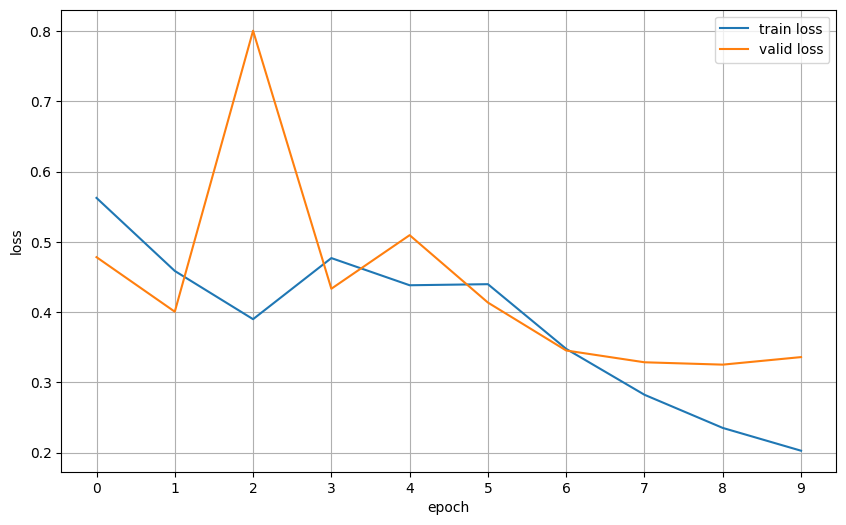

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

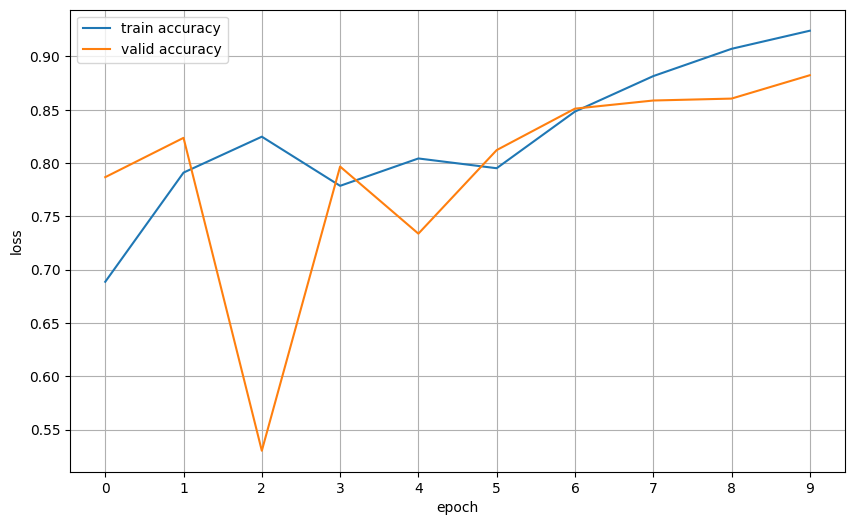

In [40]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

## Load the saved model parameters from the file `lstm.pt` into our model, restoring the best‑saved weights. Then run the evaluate function on the test DataLoader using the loaded model and loss criterion, returning the test set’s average loss and accuracy.


In [50]:
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...:  76%|███████▌  | 74/98 [00:01<00:00, 38.85it/s]

evaluating...: 100%|██████████| 98/98 [00:02<00:00, 40.69it/s]


In [51]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.357, test_acc: 0.850


## Evaluate the model performance.
 First define a function that takes raw text, applies the tokenizer to split it into words, and uses the vocabulary to convert those words into a sequence of integer IDs. It then constructs a batch‑of‑one tensor (including its length) and feeds it through the LSTM model to produce raw logits. After applying softmax to turn logits into probabilities, it selects the class with the highest probability and returns both that predicted label and its confidence score.

 Then test the result with different sentences.




In [52]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [53]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9956081509590149)

In [54]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9614872336387634)

In [55]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.7539320588111877)

In [56]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.8792877197265625)